Stochastic differential equations:
$$ dx = \mu_x(-k_x x[t] + k_{int} y[t])dt + \sqrt{2\mu_x D_x dt} \delta_x[t] $$
$$ dy = \mu_y(-k_y y[t] + k_{int} x[t] + f[t])dt + \sqrt{2\mu_y D_y dt} \delta_y[t] $$
$$ df = -\frac{f[t]}{\tau} dt + \sqrt{\frac{2\epsilon^2 dt}{\tau}} \delta_f[t] $$

Theoretical things:
- OT stretching, OT sensing, and OM refer to different techniques used to measure the mechanical properties of red blood cells (RBCs). OT stretching involves mechanically stretching RBCs using beads nonspecifically attached to the membrane with different optical trap stiffness. OT sensing, on the other hand, measures cell contour fluctuations by membrane flickering segmentation tracking of free-standing RBCs using ultrafast optical microscopy (OM). These techniques are used to study the deformability and mechanical properties of RBCs

Parameters, prior:
- Sampling rates = 40 kHz for OT stretching, 25 kHz for OT sensing, 2 kHz for OM
Considering 40 kHz as sampling rate, and 30 s the duration of the experiment. We need to sample 1.2e6 points.
So if the frequency is 40 kHz, in our simulation we need to have this relation:
$$\text{{Total simulation time}} = dt \times \text{{Number of steps}}$$ 
$$30 \, \text{{s}} = dt \times \text{{Number of steps}}$$
- Parameters 

| RBC | $k_x$ [10^-3 pN/nm] | $\mu_x$ [10^4 nm/(pN s)] | $k_y$ [10^-2 pN/nm] | $\mu_y$ [10^4 nm/(pN s)] | $k_{int}$ [10^-3 pN/nm] | $\varepsilon$ [pN] | $\tau$ [10^-2 s] | $\Theta$ [10^2 kB T/s] |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| P1 | 6.0±0.7 | 2.6±0.3 | 1.7±0.5 | 140±10 | 1.8±0.6 | 0.7±0.1 | (2±1)·10^2 | 1.3±0.2 |
| P2 | 8.1±0.5 | 2.1±0.4 | 29±8 | 31±8 | 6±2 | 2.1±0.5 | (4±1)·10^2 | 0.8±0.1 |
| H1 | 6.5±0.6 | 2.8±0.5 | 1.6±0.2 | 2.9±0.4 | 4.5±0.5 | 2.6±0.1 | 8±1 | 16±2 |
| H2 | 15.1±0.2 | 3.6±0.4 | 1.6±0.1 | 2.3±0.3 | 4.2±0.2 | 2.4±0.1 | 1.1±0.1 | 64±3 |
| H3 | 3.7±0.6 | 2.6±0.2 | 2.9±0.5 | 0.57±0.08 | 2.3±0.4 | 4.7±0.3 | 2.5±0.3 | 10±2 |
| H4 | 7.17±0.03 | 1.6±0.1 | 1.30±0.05 | 1.96±0.02 | 2.88±0.05 | 3.86±0.02 | 17±3 | 22±4 |
| H5 | 9.5±0.4 | 1.7±0.2 | 1.78±0.06 | 1.94±0.02 | 2.84±0.06 | 4.41±0.03 | 7.7±0.1 | 39±5 |

- Prior distributions,, we can just take the uniform distribution in those ranges without rescaling or anything, since the units of measurement are alsways in nm, pN and s.

| Parameter      | Prior Distribution (Range) |
| ----------- | ----------- |
| $k_{x}$     | $\mathcal{U}(3, 16)$ pN/nm       |
| $k_{y}$  | $\mathcal{U}(1, 4)$ nm/(pN s)        |
| $k_{int}$ | $\mathcal{U}(0, 5)$ pN |
| $u_{x}$ | $\mathcal{U}(0, 500)$ s |
| $u_{y}$ | $\mathcal{U}(e, f)$ (replace e and f with the actual range) |
| $u_{int}$ | $\mathcal{U}(g, h)$ (replace g and h with the actual range) |
| $\varepsilon$ | $\mathcal{U}(i, j)$ (replace i and j with the actual range) |
| $\tau$ | $\mathcal{U}(k, l)$ (replace k and l with the actual range) |
| $\sigma$ | $\mathcal{U}(m, n)$ (replace m and n with the actual range) |


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [2]:
from numba import jit
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

TO DO
- Fix the time steps (the relation between dt and simul time)
- Implement sampling time != dt
- The process is Markovin: we can extend the dynamics starting from the end of a simulation (less memory intensive if we use a sampling time different from the integration time)

### CPU 

In [3]:
@jit
def simul(N, simul_time, dt, params, random_numbers, init_state=None):
    """
    - simul_time: number of integration time steps
    """
    # Unpack parameters
    mu_x, mu_y, k_x, k_y, k_int, D_x, D_y, tau, eps = params
    
    # Unpack stochastic variables (needed for numba)
    delta_x = random_numbers[0]
    delta_y = random_numbers[1]
    delta_f = random_numbers[2]

    # Initialize state variables
    x = np.zeros((N, simul_time))
    y = np.zeros((N, simul_time))
    f = np.zeros((N, simul_time))

    # Initial conditions
    if init_state is not None:
        x[:, 0] = init_state[0]
        y[:, 0] = init_state[1]
        f[:, 0] = init_state[2]

    # Time evolution (Langvine dynamics)
    for t in range(simul_time-1):
        dx = mu_x*(-k_x*x[:, t] + k_int*y[:, t])*dt + np.sqrt(2*mu_x*D_x*dt)*delta_x[:, t]
        dy = mu_y*(-k_y*y[:, t] + k_int*x[:, t] + f[:, t])*dt + np.sqrt(2*mu_y*D_y*dt)*delta_y[:, t]
        df = -(f[:, t]/tau)*dt + np.sqrt(2*eps**2*dt/tau)*delta_f[:, t]

        x[:, t+1] = x[:, t] + dx
        y[:, t+1] = y[:, t] + dy
        f[:, t+1] = f[:, t] + df
         
    return x, y, f

In [4]:
def run_simul(N, simul_time, dt):
    
    N, simul_time = int(N), int(simul_time)

    # Define the parameters (drawn from the uniform prior)
    mu_x = np.random.uniform(0.1, 0.5, size=N)
    mu_y = np.random.uniform(0.1, 0.5, size=N)
    k_x = np.random.uniform(0.1, 0.5, size=N)
    k_y = np.random.uniform(0.1, 0.5, size=N)
    k_int = np.random.uniform(0.1, 0.5, size=N)
    D_x = np.random.uniform(0.1, 0.5, size=N)
    D_y = np.random.uniform(0.1, 0.5, size=N)
    tau = np.random.uniform(0.1, 0.5, size=N)
    eps = np.random.uniform(0.1, 0.5, size=N)

    # Initial state
    init_state = [np.random.normal(0, 1, size=N), 
                  np.random.normal(0, 1, size=N), 
                  np.random.normal(0, 1, size=N)]

    # Generate random numbers for the stochastic variables
    delta_x = np.random.normal(0, 1, size=(N, simul_time))
    delta_y = np.random.normal(0, 1, size=(N, simul_time))
    delta_f = np.random.normal(0, 1, size=(N, simul_time))
    random_numbers = [delta_x, delta_y, delta_f]

    # Run the N simulations in parallel
    x, y, f = simul(N, simul_time=simul_time, dt=dt, 
                    params=[mu_x, mu_y, k_x, k_y, k_int, D_x, D_y, tau, eps], 
                    random_numbers=random_numbers, init_state=init_state)
    
    del mu_x, mu_y, k_x, k_y, k_int, D_x, D_y, tau, eps
    del delta_x, delta_y, delta_f, random_numbers

    return x, y, f

In [ ]:
def extend_simul(N, simul_time, sample_time, dt, repetitions):
    

In [5]:
# Easy call to the simulation to compile simul()
x, y, f = run_simul(N=2, simul_time=1000, dt=0.01)

[1.43292117 0.00692067]


In [6]:
%%time
x, y, f = run_simul(N=1e1, simul_time=3e5, dt=0.000001)

[ 0.0491984   0.02477199  0.70731145 -1.62490508  0.32790303 -0.59827165
  0.13036362  1.78789082 -1.94695912 -0.11157568]
CPU times: total: 500 ms
Wall time: 624 ms


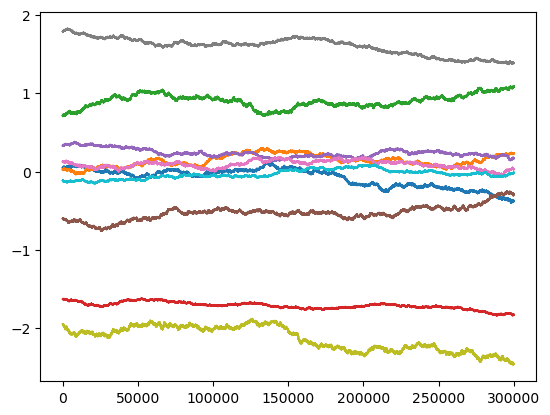

In [7]:
for n in range(10):
    plt.plot(x[n, :], label=f"Trajectory {n}")

In [ ]:
%%time
N, times = int(1e4), 10
T = int(1e3)

x = np.zeros((N*times, T))
y = np.zeros((N*times, T))
f = np.zeros((N*times, T))

for t in tqdm(range(times)):
    x_t, y_t, f_t = run_simul(N, T)

    x[N*t:N*(t+1), :] = x_t
    x[N*t:N*(t+1), :] = y_t
    x[N*t:N*(t+1), :] = f_t

    #time.sleep(1)

### GPU with torch

NOT UPDATED!!!

In [ ]:
def simul_torch(N, T, dt, params, random_numbers, init_state=None, device='cpu'):
    # Unpack parameters
    mu_x, mu_y, k_x, k_y, k_int, D_x, D_y, tau, eps = params
    
    # Unpack stochastic variables
    delta_x, delta_y, delta_f = random_numbers

    # Initialize state variables as PyTorch tensors
    x = torch.zeros((N, T), dtype=torch.float64, device=device)
    y = torch.zeros((N, T), dtype=torch.float64, device=device)
    f = torch.zeros((N, T), dtype=torch.float64, device=device)

    # Initial conditions
    if init_state is not None:
        x[:, 0] = init_state[0].clone().detach().to(torch.float64)
        y[:, 0] = init_state[1].clone().detach().to(torch.float64)
        f[:, 0] = init_state[2].clone().detach().to(torch.float64)

    # Time evolution (Langvine dynamics)
    for t in range(T-1):
        dx = mu_x*(-k_x*x[:, t] + k_int*y[:, t])*dt + torch.sqrt(2*mu_x*D_x*dt)*delta_x[:, t]
        dy = mu_y*(-k_y*y[:, t] + k_int*x[:, t] + f[:, t])*dt + torch.sqrt(2*mu_y*D_y*dt)*delta_y[:, t]
        df = -(f[:, t]/tau)*dt + torch.sqrt(2*eps**2*dt/tau)*delta_f[:, t]

        x[:, t+1] = x[:, t] + dx
        y[:, t+1] = y[:, t] + dy
        f[:, t+1] = f[:, t] + df
        
    return x, y, f


In [ ]:
def run_simul_torch(N, T):
    N, T = int(N), int(T)

    # Define the parameters (drawn from the uniform prior)
    mu_x = torch.rand(N) * 0.4 + 0.1
    mu_y = torch.rand(N) * 0.4 + 0.1
    k_x = torch.rand(N) * 0.4 + 0.1
    k_y = torch.rand(N) * 0.4 + 0.1
    k_int = torch.rand(N) * 0.4 + 0.1
    D_x = torch.rand(N) * 0.4 + 0.1
    D_y = torch.rand(N) * 0.4 + 0.1
    tau = torch.rand(N) * 0.4 + 0.1
    eps = torch.rand(N) * 0.4 + 0.1

    # Initial state
    init_state = [
        torch.normal(-20, 20, size=(N,)).clone().detach(),
        torch.normal(-20, 20, size=(N,)).clone().detach(),
        torch.normal(-0.5, 0.5, size=(N,)).clone().detach()
    ]

    # Generate random numbers for the stochastic variables
    delta_x = torch.normal(0, 1, size=(N, T))
    delta_y = torch.normal(0, 1, size=(N, T))
    delta_f = torch.normal(0, 1, size=(N, T))
    random_numbers = [delta_x, delta_y, delta_f]

    # Run the N simulations in parallel
    x, y, f = simul_torch(N, T, 0.01, [mu_x, mu_y, k_x, k_y, k_int, D_x, D_y, tau, eps], 
                          random_numbers, init_state, device='cpu')

    return x, y, f


In [ ]:
# Trying the same with torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using '" + str('cuda' if torch.cuda.is_available() else 'cpu') + "' as device")
x, y, f = run_simul_torch(N=2, T=100)